In [203]:
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels as sm
import folium
import sys
import os
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import ccf, ccovf
import statsmodels
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
import warnings 
warnings.filterwarnings('ignore')

__Introduction__

In this part, we will conduct a COVID-19 prediction under spatial (geographic region) and temporal (day) dimension for some interested states (New York, California, Florida and etc). In particular, we fit an autoregression model to predict the confirmed cases and deaths cases. In this notebook, we did not use daily average temperature as a potential feature.

__Importing Data__

In [204]:
df_covid = pd.read_csv("us_daily_processed.csv")
us_state_date_confirmed = df_covid.groupby(['Province_State','date'])['Confirmed'].sum().reset_index()
us_state_date_death = df_covid.groupby(['Province_State','date'])['Deaths'].sum().reset_index()
df_confirmed_bystate = pd.DataFrame(us_state_date_confirmed)
df_death_bystate = pd.DataFrame(us_state_date_death)
df_temp= pd.read_csv("COVID_19_us_temp.csv")
df_temp= df_temp.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
df_temp_bystate=df_temp.groupby(["Province_State","date"])['Avg','Confirmed','Deaths'].sum().reset_index()
df_temp_bystate=pd.DataFrame(df_temp_bystate)
df_temp_bystate

,Province_State,date,Avg,Confirmed,Deaths
0,Arkansas,2020-02-01,46.6,0.0,0.0
1,Arkansas,2020-02-02,55.5,0.0,0.0
2,Arkansas,2020-02-03,61.0,0.0,0.0
3,Arkansas,2020-02-04,58.7,0.0,0.0
4,Arkansas,2020-02-05,40.3,0.0,0.0
...,...,...,...,...,...
5695,Wyoming,2020-05-20,65.1,787.0,11.0
5696,Wyoming,2020-05-21,56.3,801.0,12.0
5697,Wyoming,2020-05-22,60.8,803.0,12.0
5698,Wyoming,2020-05-23,57.7,813.0,12.0


Here we use the number of confirmed and death cases during __first 80 percents of days__ for our __training data__. And we use the number of confirmed and death cases during __last 20 percents of days__ for our __testing data__ to evaluate the model.

__Part 1. ARIMA Process Model Fitting for Individual States__

In this part, we are using ARIMA process without using Temperatures as features. That is we only using the AR(p) and MA(q) part in the model. In this part, we try different potential orders (p,d,q) by hand and using the model with all (or most) AR component and MA component significant.

__Part 1.1 ARIMA Process for Confirmed Cases__

In particular, we analyze the COVID-19 confirmed cases without using temperature as potential feature for New York, California, Pennsylvania, Florida and Washington. Followings are the models we decided to use for these state

* New York: ARIMA(1,1,0)
* California: ARIMA(3,1,0)
* Pennsylvania: ARIMA(2,1,0)
* Florida: ARIMA(2,1,1)
* Washington: ARIMA(2,1,1)

Following codes are the implementation of ARIMA process with analysis part and prediction part. The analysis part contains the plot of ACF, PACF, summary table and model diagnostics. The prediction part contains the in-sample prediction, out-sample prediction.

In [205]:
def ARIMA_covid_confirmed(state,p,d,q):
    df_confirmed_s=df_temp_bystate.loc[df_temp_bystate['Province_State'] == state]
    series = df_confirmed_s['Confirmed']
    y = series.values
    
    plot_acf(y)
    plt.show()
    plot_pacf(y)
    plt.show()
    
    ts_df=pd.DataFrame(y,columns=['Confirmed'])
    n_sample = ts_df.shape[0]
    n_train=int(0.8*n_sample)+1
    n_forecast=n_sample-n_train
    #ts_df
    ts_train = ts_df.iloc[:n_train]['Confirmed']
    ts_test = ts_df.iloc[n_train:]['Confirmed']
    
    history = [x for x in ts_train]
    model = ARIMA(history,order=(p,d,q),)
    model_fit = model.fit(disp=0)
    predictions = model_fit.forecast(steps=len(ts_test))[0]
    print(model_fit.summary())
    
    residuals = pd.DataFrame(model_fit.resid)
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()
    
    plot_acf(residuals)
    plt.show()
    
    model_fit.plot_predict(dynamic=False)
    plt.title('In Sample Prediction COVID-19 Confirmed Cases in '+state)
    plt.show()
    
    for i in range(len(ts_test)):
        print('predicted=%f, expected=%f' % (int(predictions[i]), int(ts_test[i+len(ts_train)])))
    ts_pred=[]
    ts_true=[]
    for i in range(len(ts_train)):
        t1=0
        t2=ts_train[i]
        ts_pred.append(int(t1+t2))
        ts_true.append(int(t1+t2))
    for i in range(len(ts_train),n_sample):
        t1=0
        t2=predictions[i-len(ts_train)]
        ts_pred.append(int(t1+t2))
        ts_true.append(int(t1+ts_test[i])) 
    plt.plot(ts_pred,'r',label='Predicted Cases')
    plt.plot(ts_true,'y',label='True Cases')
    plt.xlabel('Date')
    plt.ylabel('The number of COVID-19 Cases')
    plt.title('Out of Sample Prediction COVID-19 Confirmed Cases in '+state)
    plt.legend()
    plt.show()  

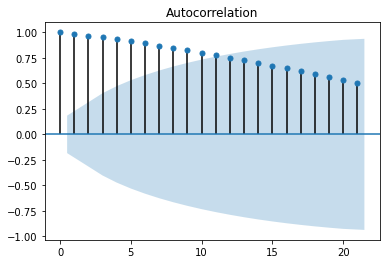

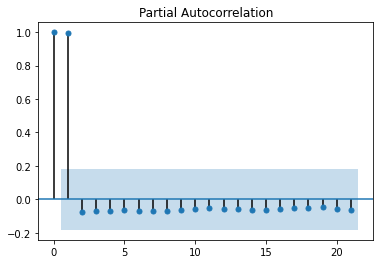

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   91
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -799.678
Method:                       css-mle   S.D. of innovations           1570.279
Date:                Sun, 07 Jun 2020   AIC                           1605.355
Time:                        12:46:47   BIC                           1612.888
Sample:                             1   HQIC                          1608.394
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3247.5870   1668.207      1.947      0.052     -22.039    6517.213
ar.L1.D.y      0.9107      0.040     22.709      0.000       0.832       0.989
                                    Roots           

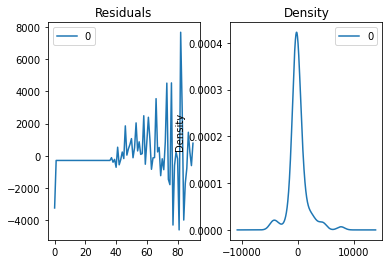

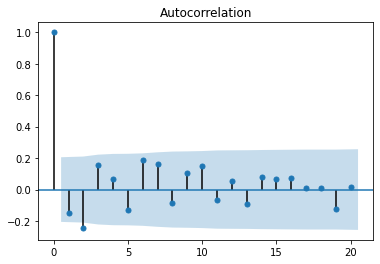

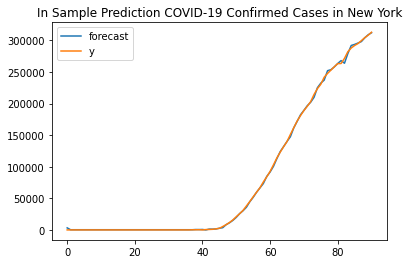

predicted=317513.000000, expected=316415.000000
predicted=321935.000000, expected=318953.000000
predicted=326252.000000, expected=321192.000000
predicted=330473.000000, expected=323978.000000
predicted=334607.000000, expected=327469.000000
predicted=338663.000000, expected=330407.000000
predicted=342646.000000, expected=333122.000000
predicted=346563.000000, expected=335395.000000
predicted=350421.000000, expected=337055.000000
predicted=354224.000000, expected=338485.000000
predicted=357978.000000, expected=340661.000000
predicted=361686.000000, expected=343051.000000
predicted=365353.000000, expected=345813.000000
predicted=368983.000000, expected=348232.000000
predicted=372579.000000, expected=350121.000000
predicted=376144.000000, expected=351371.000000
predicted=379680.000000, expected=352845.000000
predicted=383191.000000, expected=354370.000000
predicted=386678.000000, expected=356458.000000
predicted=390143.000000, expected=358154.000000
predicted=393590.000000, expected=359926

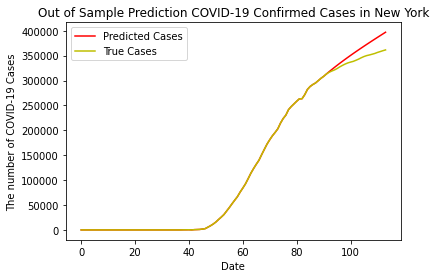

In [206]:
ARIMA_covid_confirmed('New York',1,1,0)

Based on the summary table, we see that the confirmed cases in New York is related to the confirmed cases in previous date. The larger confirmed case number of previous day, the larger confirmed case number of the next day.

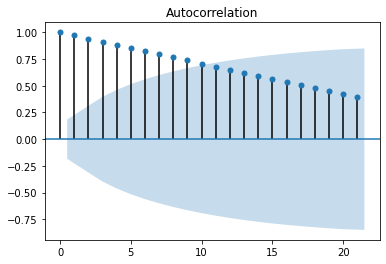

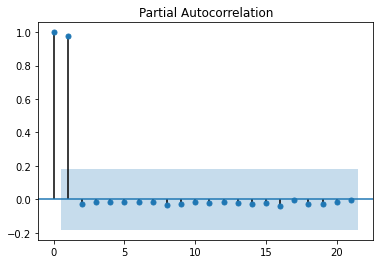

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   91
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -649.818
Method:                       css-mle   S.D. of innovations            301.534
Date:                Sun, 07 Jun 2020   AIC                           1309.637
Time:                        12:46:48   BIC                           1322.191
Sample:                             1   HQIC                          1314.701
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        679.0311    512.749      1.324      0.185    -325.939    1684.001
ar.L1.D.y      0.2077      0.099      2.093      0.036       0.013       0.402
ar.L2.D.y      0.4451      0.092      4.853      0.0

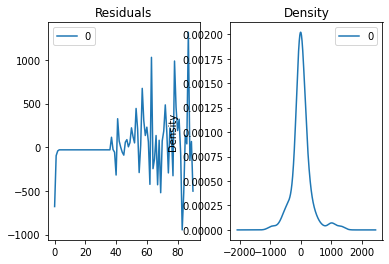

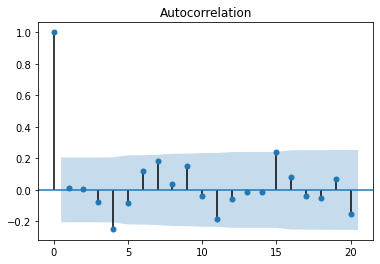

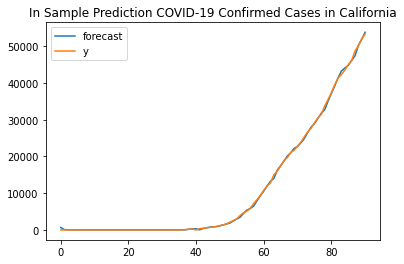

predicted=54914.000000, expected=54903.000000
predicted=56433.000000, expected=55884.000000
predicted=57877.000000, expected=58456.000000
predicted=59359.000000, expected=60616.000000
predicted=60800.000000, expected=62148.000000
predicted=62226.000000, expected=63779.000000
predicted=63644.000000, expected=66558.000000
predicted=65040.000000, expected=67600.000000
predicted=66424.000000, expected=69329.000000
predicted=67792.000000, expected=70978.000000
predicted=69146.000000, expected=72798.000000
predicted=70486.000000, expected=74871.000000
predicted=71812.000000, expected=76693.000000
predicted=73125.000000, expected=78725.000000
predicted=74424.000000, expected=80166.000000
predicted=75710.000000, expected=81457.000000
predicted=76984.000000, expected=83752.000000
predicted=78245.000000, expected=85997.000000
predicted=79494.000000, expected=88031.000000
predicted=80731.000000, expected=90252.000000
predicted=81956.000000, expected=92539.000000
predicted=83170.000000, expected=9

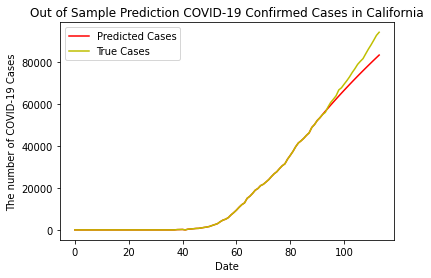

In [207]:
ARIMA_covid_confirmed('California',3,1,0)

Based on the summary table, we see that the confirmed cases in California is related to the confirmed cases in previous three days. The larger confirmed case number of previous days, the larger confirmed case number of the next day.

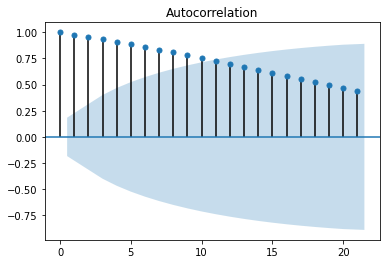

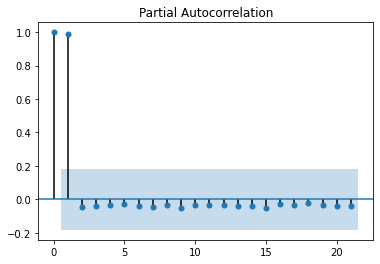

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   91
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -632.881
Method:                       css-mle   S.D. of innovations            250.617
Date:                Sun, 07 Jun 2020   AIC                           1273.763
Time:                        12:46:49   BIC                           1283.806
Sample:                             1   HQIC                          1277.815
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        558.4032    402.476      1.387      0.165    -230.434    1347.241
ar.L1.D.y      0.5140      0.096      5.330      0.000       0.325       0.703
ar.L2.D.y      0.4341      0.098      4.443      0.0

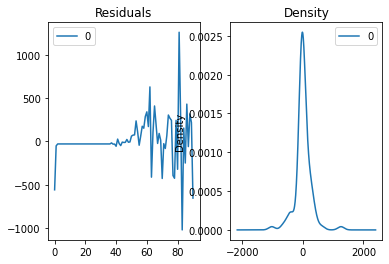

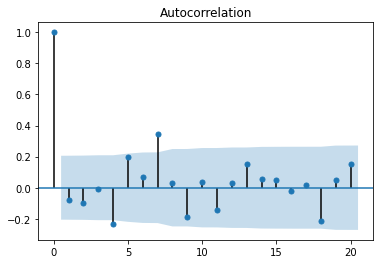

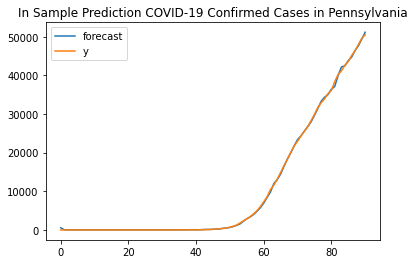

predicted=51691.000000, expected=51225.000000
predicted=52733.000000, expected=52816.000000
predicted=53817.000000, expected=53864.000000
predicted=54855.000000, expected=54800.000000
predicted=55889.000000, expected=55956.000000
predicted=56900.000000, expected=57371.000000
predicted=57897.000000, expected=58560.000000
predicted=58877.000000, expected=59939.000000
predicted=59843.000000, expected=60459.000000
predicted=60794.000000, expected=61310.000000
predicted=61732.000000, expected=62101.000000
predicted=62655.000000, expected=63105.000000
predicted=63566.000000, expected=64136.000000
predicted=64464.000000, expected=65185.000000
predicted=65350.000000, expected=65700.000000
predicted=66224.000000, expected=66669.000000
predicted=67087.000000, expected=67311.000000
predicted=67938.000000, expected=68126.000000
predicted=68780.000000, expected=69252.000000
predicted=69611.000000, expected=70211.000000
predicted=70433.000000, expected=71009.000000
predicted=71245.000000, expected=7

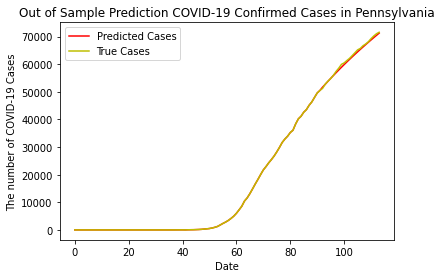

In [208]:
ARIMA_covid_confirmed('Pennsylvania',2,1,0)

Based on the summary table, we see that the confirmed cases in Pennsylvania is related to the confirmed cases in previous two days. The larger confirmed case number of previous days, the larger confirmed case number of the next day.

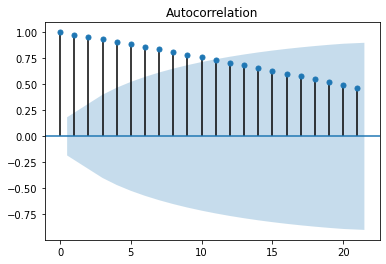

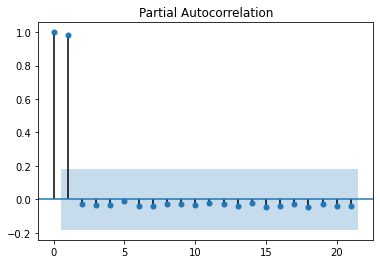

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   91
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -633.258
Method:                       css-mle   S.D. of innovations            252.113
Date:                Sun, 07 Jun 2020   AIC                           1276.517
Time:                        12:46:52   BIC                           1289.071
Sample:                             1   HQIC                          1281.582
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        379.4824    302.842      1.253      0.210    -214.076     973.041
ar.L1.D.y      0.7121      0.125      5.711      0.000       0.468       0.956
ar.L2.D.y      0.2612      0.120      2.174      0.0

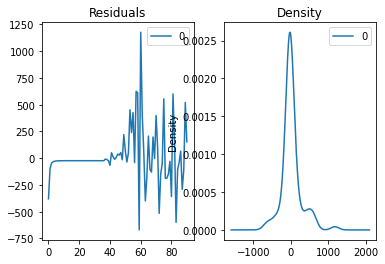

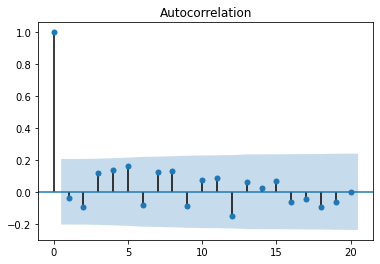

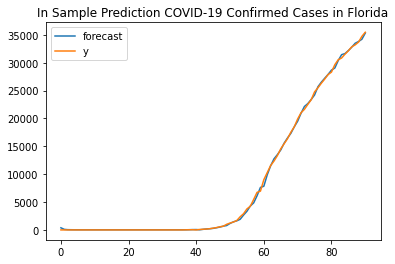

predicted=36181.000000, expected=36078.000000
predicted=36894.000000, expected=36897.000000
predicted=37600.000000, expected=37439.000000
predicted=38299.000000, expected=38002.000000
predicted=38991.000000, expected=38828.000000
predicted=39677.000000, expected=39199.000000
predicted=40356.000000, expected=40001.000000
predicted=41029.000000, expected=40596.000000
predicted=41695.000000, expected=40982.000000
predicted=42356.000000, expected=41923.000000
predicted=43011.000000, expected=42402.000000
predicted=43660.000000, expected=43210.000000
predicted=44303.000000, expected=44138.000000
predicted=44940.000000, expected=44811.000000
predicted=45573.000000, expected=45588.000000
predicted=46199.000000, expected=46442.000000
predicted=46821.000000, expected=46944.000000
predicted=47438.000000, expected=47471.000000
predicted=48049.000000, expected=48675.000000
predicted=48656.000000, expected=49451.000000
predicted=49258.000000, expected=50127.000000
predicted=49855.000000, expected=5

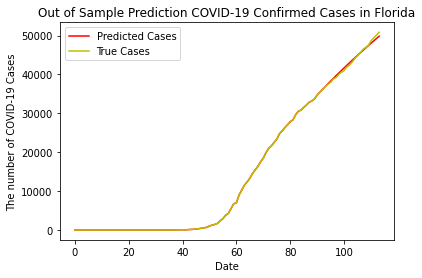

In [210]:
ARIMA_covid_confirmed('Florida',2,1,1)

Based on the summary table, we see that the confirmed cases in Florida is related to the confirmed cases in previous two days. The larger confirmed case number of previous days, the larger confirmed case number of the next day.

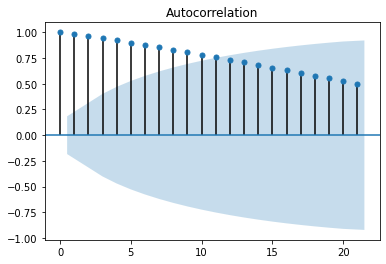

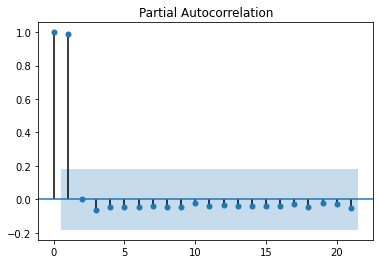

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   91
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -582.569
Method:                       css-mle   S.D. of innovations            144.852
Date:                Sun, 07 Jun 2020   AIC                           1175.139
Time:                        12:46:53   BIC                           1187.693
Sample:                             1   HQIC                          1180.204
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        158.2296    101.046      1.566      0.117     -39.816     356.276
ar.L1.D.y      0.5998      0.130      4.621      0.000       0.345       0.854
ar.L2.D.y      0.3499      0.117      3.000      0.0

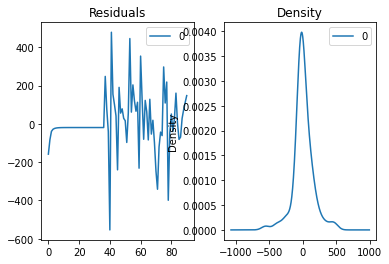

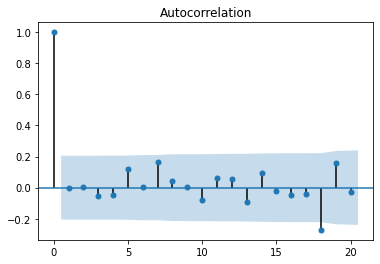

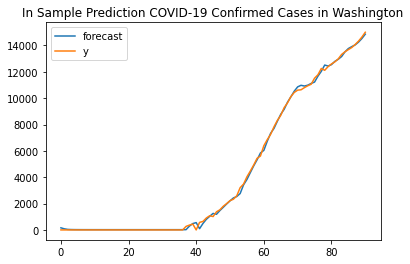

predicted=15252.000000, expected=15185.000000
predicted=15538.000000, expected=15462.000000
predicted=15805.000000, expected=15594.000000
predicted=16072.000000, expected=15905.000000
predicted=16334.000000, expected=16231.000000
predicted=16593.000000, expected=16388.000000
predicted=16848.000000, expected=16674.000000
predicted=17099.000000, expected=16891.000000
predicted=17347.000000, expected=17122.000000
predicted=17592.000000, expected=17330.000000
predicted=17833.000000, expected=17512.000000
predicted=18071.000000, expected=17773.000000
predicted=18307.000000, expected=17951.000000
predicted=18539.000000, expected=18288.000000
predicted=18769.000000, expected=18433.000000
predicted=18996.000000, expected=18611.000000
predicted=19221.000000, expected=18811.000000
predicted=19443.000000, expected=18971.000000
predicted=19663.000000, expected=19117.000000
predicted=19880.000000, expected=19265.000000
predicted=20095.000000, expected=19265.000000
predicted=20309.000000, expected=1

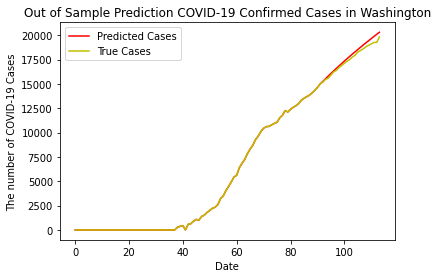

In [211]:
ARIMA_covid_confirmed('Washington',2,1,1)

Based on the summary table, we see that the confirmed cases in Washington is related to the confirmed cases in previous two days. The larger confirmed case number of previous days, the larger confirmed case number of the next day.

__Part 1.2 ARIMA Process for Death Cases__

In particular, we analyze the COVID-19 death cases without using temperature as potential feature for New York, California, Pennsylvania, Florida and Washington. Followings are the models we decided to use for these state

* New York: ARIMA(1,1,0)
* California: ARIMA(1,1,0)
* Pennsylvania: ARIMA(2,1,0)
* Florida: ARIMA(2,1,0)
* Washington: ARIMA(2,1,0)

Following codes are the implementation of ARIMA process with analysis part and prediction part. The analysis part contains the plot of ACF, PACF, summary table and model diagnostics. The prediction part contains the in-sample prediction, out-sample prediction.

In [212]:
def ARIMA_covid_death(state,p,d,q):
    df_death_s=df_temp_bystate.loc[df_temp_bystate['Province_State'] == state]
    series = df_death_s['Deaths']
    y = series.values
    
    plot_acf(y)
    plt.show()
    plot_pacf(y)
    plt.show()
    
    ts_df=pd.DataFrame(y,columns=['Deaths'])
    n_sample = ts_df.shape[0]
    n_train=int(0.8*n_sample)+1
    n_forecast=n_sample-n_train
    #ts_df
    ts_train = ts_df.iloc[:n_train]['Deaths']
    ts_test = ts_df.iloc[n_train:]['Deaths']
    
    history = [x for x in ts_train]
    model = ARIMA(history,order=(p,d,q))
    model_fit = model.fit(disp=0)
    predictions = model_fit.forecast(steps=len(ts_test))[0]
    print(model_fit.summary())
    
    residuals = pd.DataFrame(model_fit.resid)
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()
    
    plot_acf(residuals)
    plt.show()
    
    model_fit.plot_predict(dynamic=False)
    plt.title('In Sample Prediction COVID-19 Deaths Cases in '+state)
    plt.show()
    
    for i in range(len(ts_test)):
        print('predicted=%f, expected=%f' % (int(predictions[i]), int(ts_test[i+len(ts_train)])))
    ts_pred=[]
    ts_true=[]
    for i in range(len(ts_train)):
        t1=0
        t2=ts_train[i]
        ts_pred.append(int(t1+t2))
        ts_true.append(int(t1+t2))
    for i in range(len(ts_train),n_sample):
        t1=0
        t2=predictions[i-len(ts_train)]
        ts_pred.append(int(t1+t2))
        ts_true.append(int(t1+ts_test[i])) 
    plt.plot(ts_pred,'r',label='Predicted Cases')
    plt.plot(ts_true,'y',label='True Cases')
    plt.xlabel('Date')
    plt.ylabel('The number of COVID-19 Deaths Cases')
    plt.title('Out of Sample Prediction COVID-19 Death Cases in '+state)
    plt.legend()
    plt.show()  

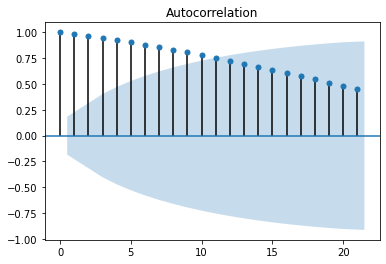

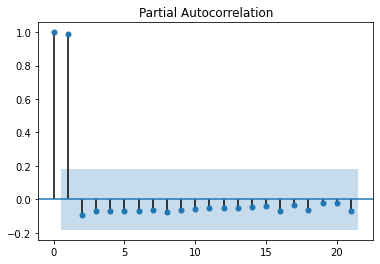

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   91
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -664.081
Method:                       css-mle   S.D. of innovations            356.140
Date:                Sun, 07 Jun 2020   AIC                           1334.162
Time:                        12:46:54   BIC                           1341.695
Sample:                             1   HQIC                          1337.201
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        257.7581    112.116      2.299      0.022      38.016     477.501
ar.L1.D.y      0.6742      0.076      8.883      0.000       0.525       0.823
                                    Roots           

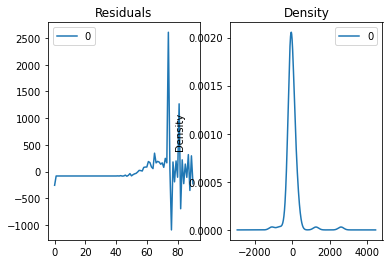

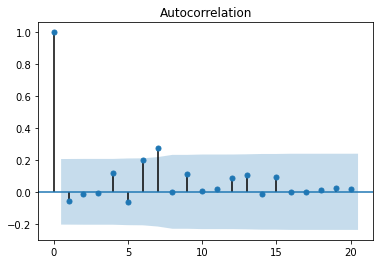

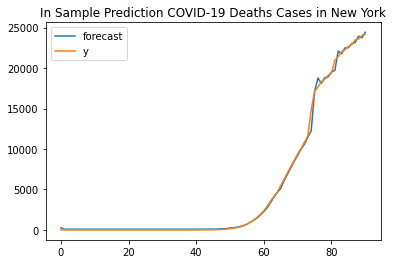

predicted=24389.000000, expected=24708.000000
predicted=24602.000000, expected=24999.000000
predicted=24829.000000, expected=25124.000000
predicted=25066.000000, expected=25623.000000
predicted=25310.000000, expected=26144.000000
predicted=25559.000000, expected=26243.000000
predicted=25810.000000, expected=26612.000000
predicted=26064.000000, expected=26641.000000
predicted=26319.000000, expected=26988.000000
predicted=26575.000000, expected=27284.000000
predicted=26831.000000, expected=27477.000000
predicted=27088.000000, expected=27641.000000
predicted=27345.000000, expected=27878.000000
predicted=27603.000000, expected=28049.000000
predicted=27860.000000, expected=28232.000000
predicted=28118.000000, expected=28339.000000
predicted=28375.000000, expected=28558.000000
predicted=28633.000000, expected=28636.000000
predicted=28891.000000, expected=28743.000000
predicted=29148.000000, expected=28853.000000
predicted=29406.000000, expected=29031.000000
predicted=29664.000000, expected=2

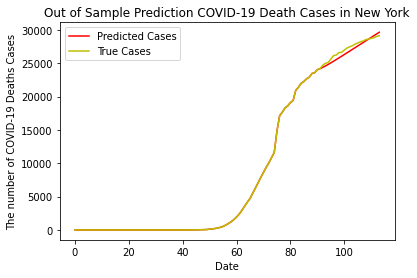

In [213]:
ARIMA_covid_death('New York',1,1,0)

Based on the summary table, we see that the death cases in New York is related to the death cases in the previous day. The larger death case number of the previous day, the larger death case number of the next day.

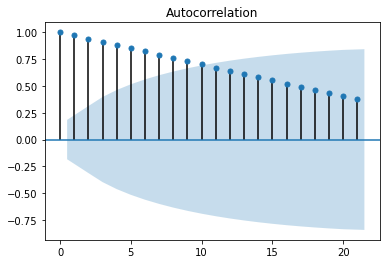

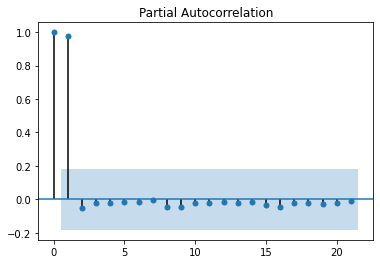

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   91
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -383.318
Method:                       css-mle   S.D. of innovations             16.207
Date:                Sun, 07 Jun 2020   AIC                            772.636
Time:                        12:46:56   BIC                            780.169
Sample:                             1   HQIC                           775.675
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.3551     12.443      1.957      0.050      -0.033      48.743
ar.L1.D.y      0.8727      0.049     17.793      0.000       0.777       0.969
                                    Roots           

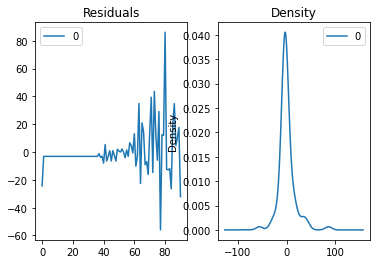

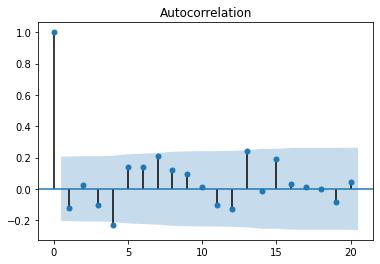

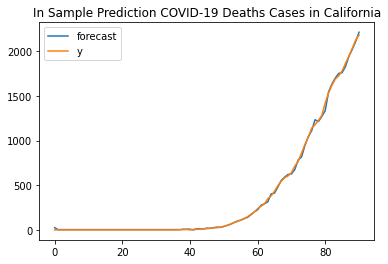

predicted=2230.000000, expected=2216.000000
predicted=2277.000000, expected=2278.000000
predicted=2321.000000, expected=2381.000000
predicted=2362.000000, expected=2464.000000
predicted=2402.000000, expected=2535.000000
predicted=2439.000000, expected=2613.000000
predicted=2475.000000, expected=2687.000000
predicted=2509.000000, expected=2716.000000
predicted=2542.000000, expected=2779.000000
predicted=2574.000000, expected=2879.000000
predicted=2605.000000, expected=2957.000000
predicted=2635.000000, expected=3052.000000
predicted=2665.000000, expected=3136.000000
predicted=2693.000000, expected=3208.000000
predicted=2722.000000, expected=3240.000000
predicted=2749.000000, expected=3279.000000
predicted=2777.000000, expected=3403.000000
predicted=2804.000000, expected=3497.000000
predicted=2830.000000, expected=3583.000000
predicted=2856.000000, expected=3666.000000
predicted=2883.000000, expected=3738.000000
predicted=2908.000000, expected=3754.000000


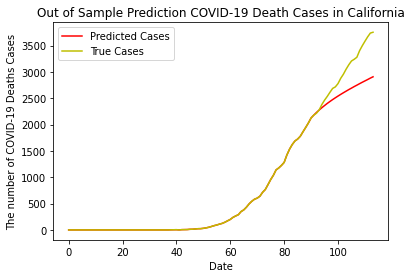

In [214]:
ARIMA_covid_death('California',1,1,0)

Based on the summary table, we see that the death cases in California is related to the death cases in the previous day. The larger death case number of the previous day, the larger death case number of the next day.

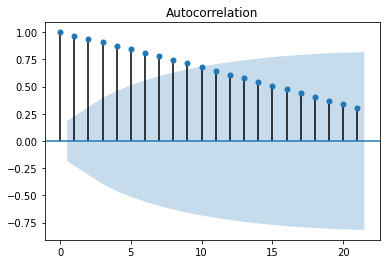

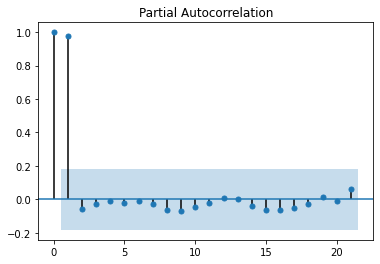

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   91
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -469.481
Method:                       css-mle   S.D. of innovations             41.907
Date:                Sun, 07 Jun 2020   AIC                            946.961
Time:                        12:46:57   BIC                            957.005
Sample:                             1   HQIC                           951.013
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.5161     18.519      1.702      0.089      -4.780      67.813
ar.L1.D.y      0.3501      0.095      3.703      0.000       0.165       0.535
ar.L2.D.y      0.4253      0.097      4.379      0.0

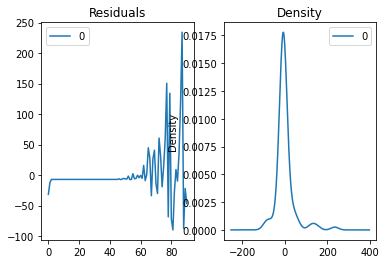

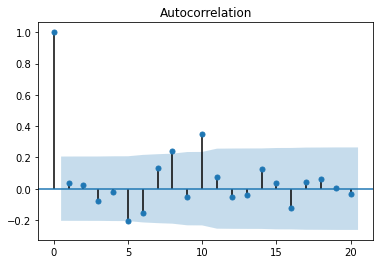

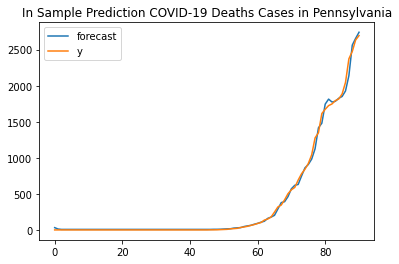

predicted=2791.000000, expected=2720.000000
predicted=2857.000000, expected=2838.000000
predicted=2928.000000, expected=3179.000000
predicted=2988.000000, expected=3345.000000
predicted=3047.000000, expected=3589.000000
predicted=3100.000000, expected=3715.000000
predicted=3150.000000, expected=3779.000000
predicted=3198.000000, expected=3806.000000
predicted=3243.000000, expected=3832.000000
predicted=3286.000000, expected=3914.000000
predicted=3327.000000, expected=4094.000000
predicted=3367.000000, expected=4288.000000
predicted=3405.000000, expected=4422.000000
predicted=3443.000000, expected=4480.000000
predicted=3480.000000, expected=4495.000000
predicted=3516.000000, expected=4515.000000
predicted=3551.000000, expected=4628.000000
predicted=3585.000000, expected=4770.000000
predicted=3620.000000, expected=4869.000000
predicted=3653.000000, expected=5010.000000
predicted=3687.000000, expected=5112.000000
predicted=3720.000000, expected=5136.000000


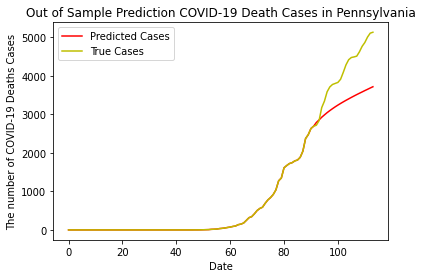

In [215]:
ARIMA_covid_death('Pennsylvania',2,1,0)

Based on the summary table, we see that the death cases in Pennsylvania is related to the death cases in the previous two days. The larger death case number of the previous days, the larger death case number of the next day.

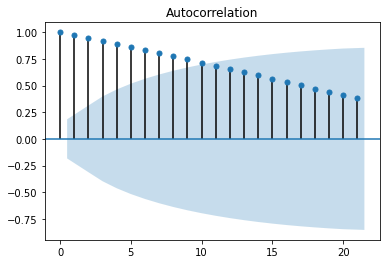

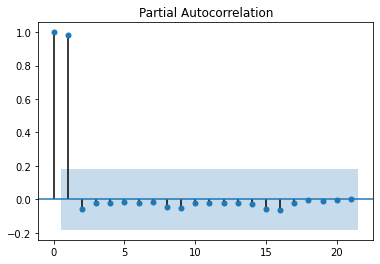

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   91
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -385.547
Method:                       css-mle   S.D. of innovations             16.662
Date:                Sun, 07 Jun 2020   AIC                            779.095
Time:                        12:46:58   BIC                            789.138
Sample:                             1   HQIC                           783.146
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9691      7.401      2.158      0.031       1.464      30.474
ar.L1.D.y      0.3553      0.094      3.777      0.000       0.171       0.540
ar.L2.D.y      0.4211      0.095      4.428      0.0

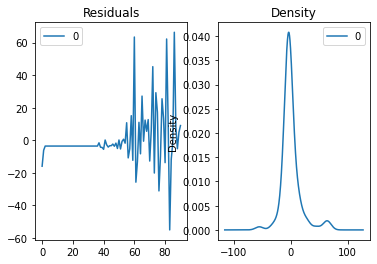

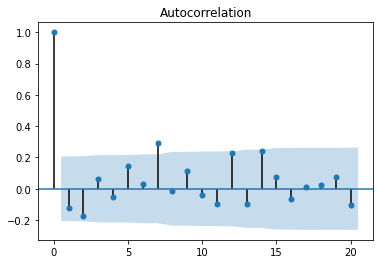

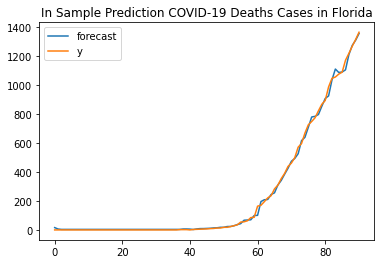

predicted=1404.000000, expected=1379.000000
predicted=1443.000000, expected=1399.000000
predicted=1478.000000, expected=1471.000000
predicted=1510.000000, expected=1539.000000
predicted=1540.000000, expected=1600.000000
predicted=1568.000000, expected=1669.000000
predicted=1593.000000, expected=1715.000000
predicted=1618.000000, expected=1721.000000
predicted=1641.000000, expected=1735.000000
predicted=1663.000000, expected=1779.000000
predicted=1684.000000, expected=1827.000000
predicted=1705.000000, expected=1875.000000
predicted=1724.000000, expected=1917.000000
predicted=1744.000000, expected=1964.000000
predicted=1762.000000, expected=1973.000000
predicted=1781.000000, expected=1997.000000
predicted=1798.000000, expected=2052.000000
predicted=1816.000000, expected=2096.000000
predicted=1834.000000, expected=2144.000000
predicted=1851.000000, expected=2190.000000
predicted=1868.000000, expected=2233.000000
predicted=1885.000000, expected=2237.000000


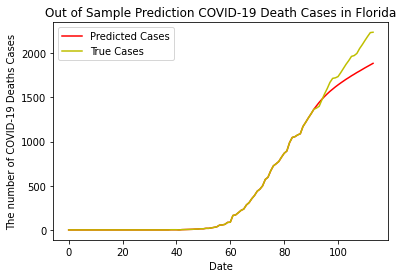

In [216]:
ARIMA_covid_death('Florida',2,1,0)

Based on the summary table, we see that the death cases in Florida is related to the death cases in previous two days. The larger death case number of previous days, the larger death case number of the next day.

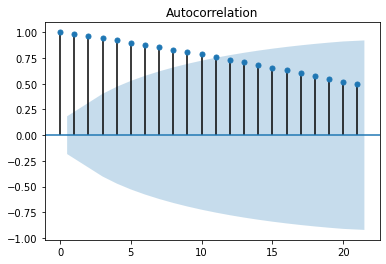

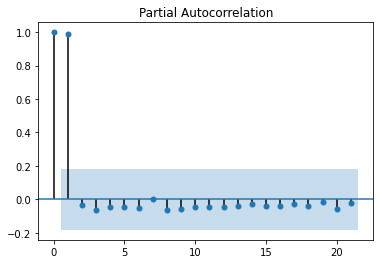

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   91
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -332.158
Method:                       css-mle   S.D. of innovations              9.276
Date:                Sun, 07 Jun 2020   AIC                            672.316
Time:                        12:47:01   BIC                            682.359
Sample:                             1   HQIC                           676.368
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.7230      3.004      2.904      0.004       2.835      14.611
ar.L1.D.y      0.2299      0.092      2.510      0.012       0.050       0.409
ar.L2.D.y      0.4583      0.092      4.995      0.0

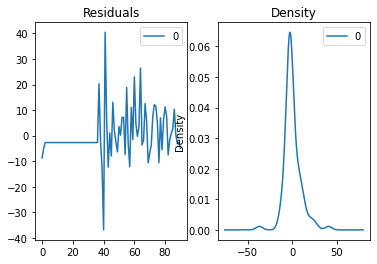

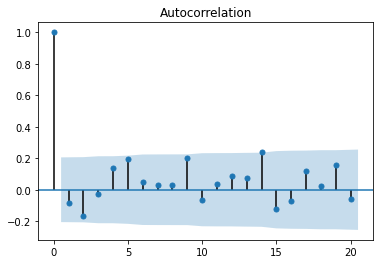

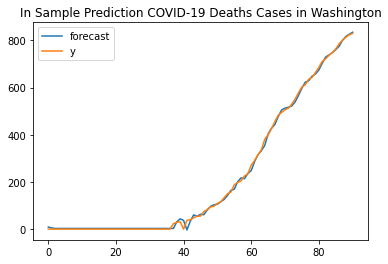

predicted=838.000000, expected=834.000000
predicted=846.000000, expected=841.000000
predicted=854.000000, expected=862.000000
predicted=862.000000, expected=870.000000
predicted=871.000000, expected=891.000000
predicted=879.000000, expected=905.000000
predicted=887.000000, expected=921.000000
predicted=896.000000, expected=931.000000
predicted=905.000000, expected=945.000000
predicted=913.000000, expected=962.000000
predicted=922.000000, expected=974.000000
predicted=930.000000, expected=983.000000
predicted=939.000000, expected=991.000000
predicted=948.000000, expected=999.000000
predicted=956.000000, expected=1001.000000
predicted=965.000000, expected=1002.000000
predicted=974.000000, expected=1031.000000
predicted=982.000000, expected=1037.000000
predicted=991.000000, expected=1044.000000
predicted=1000.000000, expected=1050.000000
predicted=1009.000000, expected=1050.000000
predicted=1017.000000, expected=1061.000000


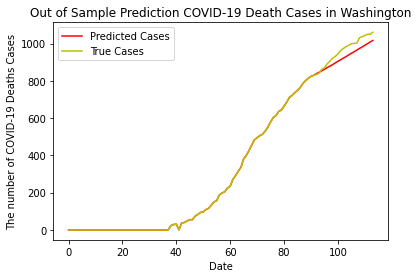

In [218]:
ARIMA_covid_death('Washington',2,1,0)

Based on the summary table, we see that the death cases in Washington is related to the death cases in previous two days. The larger death case number of previous days, the larger death case number of the next day.

### Summary

1. Based on the previous analysis, we see that the ARIMA model for predicting confirmed cases in Pennsylvania and Florida is already good now. However, for the rest cases, we may expect to improve our prediction by adding temperatures and other features into the model.

2. Besides, in most cases, the diagnostics show that the residual is not perfectly equal to a white noise. Therefore, there might be some other features that we have not captured in the model. This also motivates us to add other features in our model.